In [4]:
# Visualization imports & configuration
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20

%matplotlib inline

In [5]:
import time

from sklearn.pipeline import Pipeline

In [6]:
location = "data//"

In [7]:
azdias = pd.read_pickle(location+'azdias_final.pkl')

In [8]:
azdias.shape

(737287, 458)

## Part 2: Customer Segmentation Report

The main bulk of your analysis is in this part of the project. 

Here, we use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. 

By the end of this part, we will able to describe: 

(1) Which parts of the general population are *more* likely to be part of the mail-order company's main customer base?  
(2) Which parts of the general population are *less* likely to be part of the mail-order company's main customer base? 

We can begin by applying principle component analysis (PCA) to reduce the number of features.

# Principle Component Analysis (PCA)

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA().fit(azdias)
len(pca.explained_variance_ratio_)

458

In [11]:
pca_variance_by_component = pd.DataFrame(pca.explained_variance_ratio_)
pca_variance_by_component.index += 1
pca_variance_by_component.head()

,0
1,0.066676
2,0.040948
3,0.039697
4,0.030616
5,0.019067


In [12]:
cumulative_pca_variance = pd.DataFrame(pca_variance_by_component.cumsum().values, columns = ['Cumulative Variance'])
cumulative_pca_variance.head()

,Cumulative Variance
0,0.066676
1,0.107624
2,0.147321
3,0.177938
4,0.197004


In [13]:
centile85 = cumulative_pca_variance[cumulative_pca_variance['Cumulative Variance']>0.85].index[0]
centile90 = cumulative_pca_variance[cumulative_pca_variance['Cumulative Variance']>0.9].index[0]
centile95 = cumulative_pca_variance[cumulative_pca_variance['Cumulative Variance']>0.95].index[0]

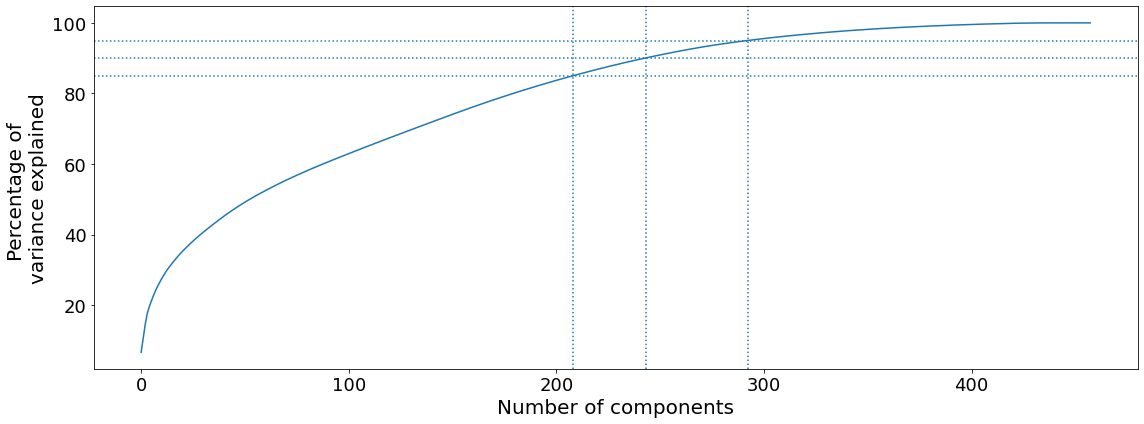

In [14]:
plt.figure(figsize = (16,6))
plt.plot(cumulative_pca_variance*100)
plt.axhline(85, linestyle = 'dotted')
plt.axvline(centile85, linestyle = 'dotted')
plt.axhline(95, linestyle = 'dotted')
plt.axvline(centile95, linestyle = 'dotted')
plt.axhline(90, linestyle = 'dotted')
plt.axvline(centile90, linestyle = 'dotted')
plt.xlabel('Number of components')
plt.ylabel('Percentage of \nvariance explained')
plt.tight_layout()
plt.savefig('images/PCA.png')

In [15]:
print(centile85,centile90,centile95)
print(centile85/len(pca.explained_variance_ratio_), centile90/len(pca.explained_variance_ratio_), centile95/len(pca.explained_variance_ratio_))

208 243 292
0.45414847161572053 0.5305676855895196 0.6375545851528385


With 45\% of the components (208 out of 458) we can explain 85% of variance the data.

In [16]:
pca = PCA(n_components = 208).fit(azdias)
azdias_small = pd.DataFrame(pca.transform(azdias))

In [17]:
pca_variance_by_component = pd.DataFrame(pca.explained_variance_ratio_)
pca_variance_by_component.index += 1
pca_variance_by_component.head(10)

,0
1,0.066676
2,0.040948
3,0.039697
4,0.030616
5,0.019067
6,0.016312
7,0.015334
8,0.013579
9,0.012479
10,0.011323


By visual inspection we can see that the top 4 explain the most variance.

In [18]:
pca_variance_by_component[0:4].sum()

0    0.177938
dtype: float64

Let us now look at these four components, starting with component 1.

By looking at the highest positive weightings we can discover which properties make a person ***more*** likely to be a customer.

In [19]:
weightings = pca.components_[0]
features_df = pd.DataFrame(weightings, index = azdias.columns, columns = ["weightings"])
features_df.sort_values(by = "weightings", ascending = False, inplace = True)
features_df.head(5)

,weightings
MOBI_REGIO,0.138722
PLZ8_ANTG1,0.131941
KBA13_ANTG1,0.131334
LP_STATUS_FEIN,0.129334
KBA05_ANTG1,0.128395


Checking with the Excel documentation, we can understand what each of these are. They are as follows, where I have grouped appropriate items together:

(MOBI_REGIO) Higher mobility  
(KBA13_ANTG1) very high mobility 
 
(PLZ8_ANTG1)  number of 1-2 family houses in the PLZ8  
(KBA05_ANTG1) number of 1-2 family houses in the cell 

(LP_STATUS_FEIN)  Higher income 

Now, by looking at the highest negative weightings, we can discover which properties make a person ***less*** likely to be a customer.

In [20]:
weightings = pca.components_[0]
features_df = pd.DataFrame(weightings, index = azdias.columns, columns = ["weightings"])
features_df.sort_values(by = "weightings", ascending = False, inplace = True)
features_df.tail(5)

,weightings
PLZ8_ANTG4,-0.125515
KBA13_BAUMAX,-0.125922
KBA13_ANTG4,-0.126573
KBA13_ANTG3,-0.130194
PLZ8_ANTG3,-0.130898


(KBA13_ANTG4) low mobility       
(KBA13_ANTG3)  middle mobility   

(PLZ8_ANTG4)  number of family houses containing more than 10 people in the neighbourhood    
(KBA13_BAUMAX)   family homes containing higher numbers of people    
(PLZ8_ANTG3) number of family houses containing 6-10 people in the PLZ8     

Before summarizing, let us note that these categories are the opposite of what we found above as we would expect. This serves as an error check because if this had not been the case we would have had to recheck all the preceding steps to figure out why our expectations had been breached.

**Summary: Component 1 tracks the moving patterns, the size of houses and the social status.**

**More likely to be customers:**
- higher mobility
- houses with fewer people
- higher social status

**Less likely to be customers:**
- low mobility
- houses with more people
- lower social status

Let us use a function to look up the attributes in the Excel documentation. (We'll still need to do a little manually,)

In [21]:
file_loc = "D:\\UDACITY-CAPSTONE-ARVATO\\"
attribute_description = pd.read_excel(file_loc+'DIAS Information Levels - Attributes 2017.xlsx', usecols='B:E', dtype='str', skiprows=1)
# (file_loc+'DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str', skiprows=1)

In [22]:
def get_features_from_pca(pca_component, features):
    ''' For a particular pca_component, print out the description of each feature'''    
    weightings = pca_component
    features_df = pd.DataFrame(weightings, index = azdias.columns, columns = ["weightings"])
    features_df.sort_values(by = "weightings", ascending = False, inplace = True)
    print("-------Positive weightings-------")
    for attribute in features_df.head(5).index:
        try: 
            #print((attr_values[attr_values.Attribute == attribute[0]]).Description.values[0])
            print(attribute_description[attribute_description.Attribute == attribute].Description.values[0], end = " ")
            print("("+attribute+")")
        except:
            print("Meaning not found in documentation:" + "("+attribute+")")
            pass
            
    print
    print("-------Negative weightings-------")
    for attribute in features_df.tail(5).index:
        try:
            #print((attr_values[attr_values.Attribute == attribute[0]]).Description.values[0])
            print(attribute_description[attribute_description.Attribute == attribute].Description.values[0], end = " ")
            print("("+attribute+")")
        except:
            print("Meaning not found in documentation:" + " ("+attribute+")")
            pass
            

In [23]:
get_features_from_pca(pca.components_[1], azdias.columns)

-------Positive weightings-------
dominating movement in the person's youth (avantgarde or mainstream) (PRAEGENDE_JUGENDJAHRE)
financial typology: investor (FINANZ_ANLEGER)
online affinity (ONLINE_AFFINITAET)
financial typology: money saver (FINANZ_SPARER)
Meaning not found in documentation:(CJT_TYP_1)
-------Negative weightings-------
age through prename analysis  (ALTERSKATEGORIE_GROB)
Meaning not found in documentation: (CJT_TYP_6)
Meaning not found in documentation: (CJT_TYP_5)
Meaning not found in documentation: (CJT_TYP_4)
financial typology: be prepared (FINANZ_VORSORGER)


Found manually from the documentation:  
CJT_TYP : Customer-Journey-Typology relating to the preferred information and buying channels of consumers  
        
-------Positive weightings-------  
CJT_TYP_1 Advertising- and Consumptionminimalist  

-------Negative weightings-------  
CJT_TYP_6 Advertising-Enthusiast with restricted Cross-Channel-Behaviour  
CJT_TYP_5 Advertising- and Cross-Channel-Enthusiast  
CJT_TYP_4 advertisinginterested Online-shopper   


*Interestingly, this suggest that when we were cleaning the data, we need not have set this as a categorical variable because there does seem to be a natural numerical ordering with 1 being uninterested in advertising and 6 being enthusiastic about advertising. (It is tricky though because this typology also include other elements such as store versus online which do not have a natural ordering.)*

**Summary: Component 2 tracks the online affinity, whether the person's youth was dominated by avantgarde or mainstream movements and the financial typology.**
    
**More likely to be customers:**
- financial typology: investor or money saver
- less enthusiastic about advertising
- lower online affinity (as expected for a mail-order company)

**Less likely to be customers:**
- financial typology: be prepared
- more enthusiastic about advertising

In [24]:
get_features_from_pca(pca.components_[2], azdias.columns)

-------Positive weightings-------
share of BMW & Mercedes Benz within the PLZ8 (KBA13_HERST_BMW_BENZ)
share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.) (KBA13_SEG_OBEREMITTELKLASSE)
share of MERCEDES within the PLZ8 (KBA13_MERCEDES)
share of BMW within the PLZ8 (KBA13_BMW)
number of cars with less than 5 seats in the PLZ8 (KBA13_SITZE_4)
-------Negative weightings-------
share of cars with max speed between 140 and 210 km/h within the PLZ8 (KBA13_KMH_140_210)
Meaning not found in documentation: (CJT_TYP_5)
share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8 (KBA13_SEG_KLEINWAGEN)
Meaning not found in documentation: (CJT_TYP_3)
number of cars with 5 seats in the PLZ8 (KBA13_SITZE_5)


**Summary: Component 3 tracks the type of car that the person uses.**

**More likely to be customers:**
- drives more expensive cars
- drives smaller cars

**Less likely to be customers:**
- drives less expensive cars
- drives bigger cars


In [25]:
get_features_from_pca(pca.components_[3], azdias.columns)

-------Positive weightings-------
Meaning not found in documentation:(D19_GESAMT_ANZ_24)
Meaning not found in documentation:(D19_VERSAND_ANZ_24)
Meaning not found in documentation:(D19_GESAMT_ANZ_12)
financial typology: be prepared (FINANZ_VORSORGER)
age through prename analysis  (ALTERSKATEGORIE_GROB)
-------Negative weightings-------
financial typology: unremarkable (FINANZ_UNAUFFAELLIGER)
Meaning not found in documentation: (RT_KEIN_ANREIZ)
financial typology: investor (FINANZ_ANLEGER)
Meaning not found in documentation: (VK_DISTANZ)
Meaning not found in documentation: (VK_ZG11)


D19_GESAMT_ANZ_ and D19_GESAMT_ANZ are all about transaction activities in the last 12 or 24 months.  
RT_KEIN_ANREIZ is undocumented.  
All VK_ are undocumented.  

**Summary: Component 4 tracks the finance typology of the person and their age**

**More likely to be customers:**
- lower age
- have made fewer transactions in the last 12 or 24 months
- financial typology: "be prepared"

**Less likely to be customers:**
- financial typology: "unremarkable" and "investor"

**Note: the financial typology here contradicts that from component 2**

**Full Summary**

**More likely to be customers:**
- higher social status
- higher mobility
- live in neighborhoods containing houses with fewer people
- less enthusiastic about advertising
- lower online affinity (as expected for a mail-order company)
- lower age
- have made fewer transactions in the last 12 or 24 months
- drives more expensive, smaller cars

**Less likely to be customers:**
- lower social status
- low mobility
- live in neighborhoods containing houses with more people
- more enthusiastic about advertising
- drives less expensive, bigger cars




# K-means clustering

In [26]:
from sklearn.cluster import KMeans
# Initialize list to store sum of squared distances of samples to their closest cluster center
sum_squared_distances = []
k_values = np.arange(1,30)

for k in k_values:
    print(k, end = " ")
    kmeans = KMeans(n_clusters = k, init = 'k-means++').fit(azdias_small.sample(20000))
    sum_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

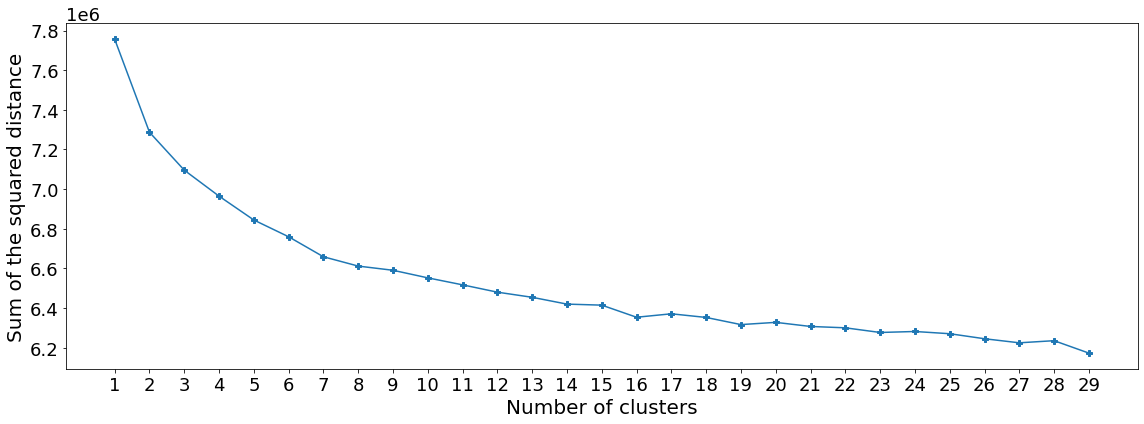

In [27]:
plt.figure(figsize = (16,6))
plt.plot(k_values, sum_squared_distances, marker = "P")
plt.xlabel('Number of clusters')
plt.ylabel('Sum of the squared distance')
plt.xticks(k_values)
plt.tight_layout()
plt.savefig('images/Elbow_plot.png')

Visual inspection of the plot of the sum of the squared distances (inertia) as a function of the number of clusters does not reveal an "elbow" (i.e., a point at which there is a sharp drop-off in error). However, the sharpest drop seems to be before 11 clusters.

In [28]:
# Final parameters chosen for PCA and KMeans
num_pca_components = 209
num_k_means_clusters = 10

In [29]:
pca_and_kmeans_pipeline = Pipeline([ ('reduce_dimensioniality', PCA(num_pca_components)),
                                    ('find_clusters', KMeans(num_k_means_clusters))  
                                  ])

In [30]:
pca_and_kmeans_pipeline.fit(azdias)

Pipeline(steps=[('reduce_dimensioniality', PCA(n_components=209)),
                ('find_clusters', KMeans(n_clusters=10))])

In [31]:
azdias['Cluster Number'] = pca_and_kmeans_pipeline.predict(azdias)

In [32]:
clusters_azdias = pd.DataFrame(azdias['Cluster Number'].value_counts().sort_index())

In [33]:
clusters_azdias.to_pickle(location+'clusters_azdias.pkl')

In [34]:
customers = pd.read_pickle(location+'customers_final.pkl')

In [35]:
pca_and_kmeans_pipeline.fit(customers)

Pipeline(steps=[('reduce_dimensioniality', PCA(n_components=209)),
                ('find_clusters', KMeans(n_clusters=10))])

In [36]:
customers['Cluster Number'] = pca_and_kmeans_pipeline.predict(customers)

In [37]:
clusters_customers = pd.DataFrame(customers['Cluster Number'].value_counts().sort_index())

In [38]:
clusters_customers.to_pickle(location+'clusters_customers.pkl')

In [39]:
clusters_customers.head()

,Cluster Number
0,12908
1,17836
2,13910
3,18684
4,451


In [40]:
clusters_azdias.head()

,Cluster Number
0,58561
1,46650
2,94423
3,104787
4,64971


In [41]:
all_clusters = clusters_azdias.join(clusters_customers, lsuffix='_azdias',rsuffix='_customers')
all_clusters.columns = ["Gen Pop", "Customers"]
all_clusters.index.names = ['Cluster Number']
all_clusters.index = all_clusters.index+1

In [42]:
all_clusters.head()

,Gen Pop,Customers
Cluster Number,,
1,58561,12908
2,46650,17836
3,94423,13910
4,104787,18684
5,64971,451


In [43]:
gen_pop_sum = all_clusters['Gen Pop'].sum()
customers_sum = all_clusters['Customers'].sum()
all_clusters['Gen Pop'] = all_clusters['Gen Pop']/gen_pop_sum
all_clusters['Customers'] = all_clusters['Customers']/customers_sum

In [44]:
all_clusters

,Gen Pop,Customers
Cluster Number,,
1,0.079428,0.096152
2,0.063273,0.132861
3,0.128068,0.103616
4,0.142125,0.139177
5,0.088122,0.003360
6,0.133295,0.037781
7,0.103839,0.074326
8,0.064788,0.158038
9,0.070122,0.183842


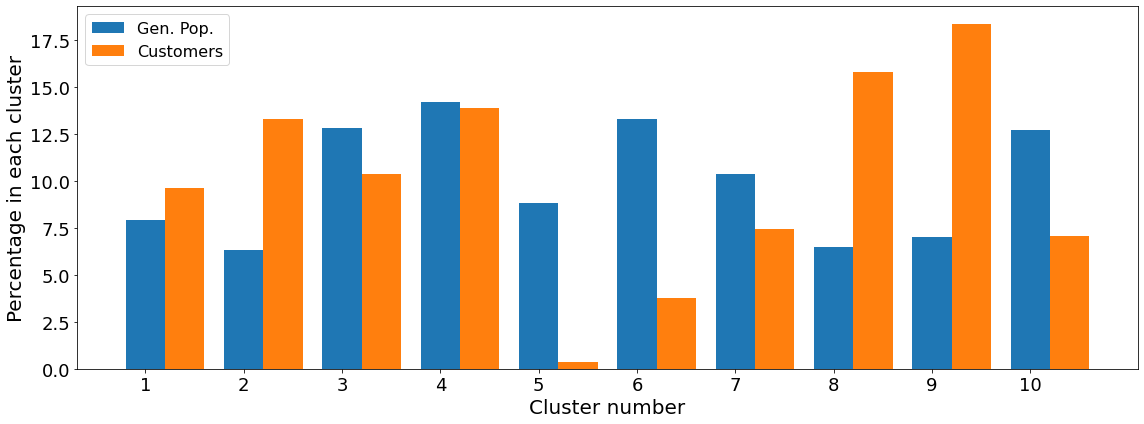

In [45]:
# Plot clusters 
plt.figure(figsize=(16,6));

x_values = np.arange(1, num_k_means_clusters+1, 1)    # the x locations for the groups
width = 0.4         # the width of the bars

plt.xlabel('Cluster number')
plt.ylabel('Percentage in each cluster')
plt.bar(x_values, all_clusters['Gen Pop']*100, width, label = "Gen. Pop.", bottom=0);
plt.bar(x_values + width, all_clusters['Customers']*100, width, label = "Customers", bottom=0);
plt.legend(fontsize = 16)
plt.xticks(x_values);
plt.tight_layout()
plt.savefig('images/Clusters.png')

Clusters 4, 6, 7, 10 are overrepresented in the customers dataset whereas Clusters 1 and 3 are underrepresented. 

Thus the properties of clusters 4, 6, 7, 10 are the ones to target in any future advertising campaigns.

In [46]:
all_clusters['Gen Pop'].describe()

count    10.000000
mean      0.100000
std       0.030655
min       0.063273
25%       0.072448
50%       0.095980
75%       0.127786
max       0.142125
Name: Gen Pop, dtype: float64

In [47]:
print(all_clusters['Gen Pop'].describe()['mean']-all_clusters['Gen Pop'].describe()['std'])
print(all_clusters['Gen Pop'].describe()['min'])

0.06934541791881242
0.06327251124731617


In [48]:
print(all_clusters['Gen Pop'].describe()['mean']+all_clusters['Gen Pop'].describe()['std'])
print(all_clusters['Gen Pop'].describe()['max'])

0.13065458208118758
0.14212511545707437


For the general population we find that the maximum and minimum percentages are just over one standard deviation of the median value, as we would expect.

In [49]:
all_clusters['Customers'].describe()

count    10.000000
mean      0.100000
std       0.055538
min       0.003360
25%       0.071717
50%       0.099884
75%       0.137598
max       0.183842
Name: Customers, dtype: float64

In [50]:
print(all_clusters['Customers'].describe()['mean']-all_clusters['Gen Pop'].describe()['std'])
print(all_clusters['Customers'].describe()['mean']-2*all_clusters['Gen Pop'].describe()['std'])
print(all_clusters['Customers'].describe()['min'])

0.06934541791881244
0.038690835837624865
0.0033595041937934836


In [51]:
print(all_clusters['Customers'].describe()['mean']+all_clusters['Gen Pop'].describe()['std'])
print(all_clusters['Customers'].describe()['mean']+2*all_clusters['Gen Pop'].describe()['std'])
print(all_clusters['Customers'].describe()['mean']+3*all_clusters['Gen Pop'].describe()['std'])
print(all_clusters['Customers'].describe()['max'])

0.13065458208118758
0.16130916416237515
0.19196374624356272
0.18384160421912013


For the customers we find that the maximum and minimum percentages are over three standard deviations from the median value.